# Data Science In Practice: Problem Set 3
Authors: Valentin Meylan, Antoine Marchal, Lionel Brodard, Allan Bellahsene

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
%matplotlib inline
import time
import itertools
import os

from datetime import datetime
from google.oauth2 import service_account
from google.cloud import bigquery

file_directory = 'file.json'
credentials = service_account.Credentials.from_service_account_file(file_directory)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = file_directory

# The style of the figure can be set globally using the matplotlib rc parameters.
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = [10,6]

import networkx as nx
ntw = nx.read_edgelist('ntw.txt')

In [2]:
def query_database():
    import sys
    client = bigquery.Client()

    query = """
    SELECT 
      *
    FROM
      `patents-public-data.patents.publications` AS patentsdb
    WHERE publication_date > 2016
    AND substr(cpc[OFFSET(0)], 1,6) = 'G06Q30'
    """
        
    # cpc.code LIKE 'G06Q30%'
    # substr(cpc.code, 1,6) = 'G06Q30'
    # substr(cpc[OFFSET(0)], 1,6) = 'G06Q30'
    
    print('running query')
    
    query_job = client.query(query)
    try:
        print('trying job')
        iterator = query_job.result(timeout=60)
        rows = list(iterator)
        df = pd.DataFrame(data = [list(x.values()) for x in rows],
                          columns = list(rows[0].keys())
                         )
        df.to_csv('raw_bigquery.csv', index = False)
        time.sleep(3)
    except Exception as e:
        print(e)    

query_database()

running query
trying job
400 No matching signature for function SUBSTR for argument types: STRUCT<code STRING, inventive BOOL, first BOOL, ...>, INT64, INT64. Supported signatures: SUBSTR(STRING, INT64, [INT64]); SUBSTR(BYTES, INT64, [INT64]) at [7:9]

(job ID: 63b921fd-9b35-495d-8c17-60cd45a68c8b)

                 -----Query Job SQL Follows-----                  

    |    .    |    .    |    .    |    .    |    .    |    .    |
   1:
   2:    SELECT 
   3:      *
   4:    FROM
   5:      `patents-public-data.patents.publications` AS patentsdb
   6:    WHERE publication_date > 2016
   7:    AND substr(cpc[OFFSET(0)], 1,6) = 'G06Q30'
   8:    
    |    .    |    .    |    .    |    .    |    .    |    .    |


## Network analysis

In [3]:
def compute_basic_stats(graph: nx.Graph()):
    nb_nodes = graph.order()
    nb_edges = graph.size() 
    avg_degree  = 2*nb_edges / nb_nodes
    print('[nb_nodes, nb_edges, avg_degree]: ', [nb_nodes, nb_edges, np.around(avg_degree,2)])

In [4]:
def compute_degrees_statistics(graph: nx.Graph()):
    # networkx.Graph.degree(): This object provides an iterator for (node, degree) 
    # as well as lookup for the degree for a single node.
    network_degrees = dict(graph.degree()) 
    s = pd.Series(network_degrees, name = 'degrees') # create series out of network_degrees dict
    degrees_df = pd.DataFrame(s)

    range_percentiles = [0.05, 0.99]

    # Compute summary statistics, 5th and 99th percentiles
    summary_stats = pd.concat([degrees_df.describe(), degrees_df.quantile(range_percentiles)]) 
        
    # nx.degree_centrality(nx.Graph()): Compute the degree centrality for nodes.
    # The degree centrality for a node v is the fraction of nodes it is connected to.
    # The degree centrality values are normalized by dividing by the maximum possible 
    # degree in a simple graph n-1 where n is the number of nodes in G.
    
    degree_centrality = nx.degree_centrality(graph)
    s = pd.Series(degree_centrality, name='degree centrality') 
    degrees_centrality_df = pd.DataFrame(s)
    degrees_centrality_df = degrees_centrality_df.sort_values(by = 'degree centrality', ascending=False)
    display(degrees_centrality_df.head(10))
    
    desc = pd.concat([degrees_centrality_df.describe(), degrees_centrality_df.quantile(range_percentiles)]) 
    desc = pd.concat([summary_stats, desc], axis = 1)
    display(desc)
    
    print('''    We notice from the above summary statistics that we have on 
    average a degree of ''', np.around(summary_stats.loc['mean'].values[0],2), '''
    with a median at ''', summary_stats.loc['50%'].values[0], '''degrees, 
    highlighting the effect of a high standard deviation of ''', 
    np.around(summary_stats.loc['std'].values[0],2),
    '''\n\n    The degree centrality is the relative degree out of all nodes.
    We notice that while the max is connected to 25% out of all nodes, the 
    99th percentile is at best connected to 5% of all nodes.''')

In [5]:
def compute_hist(graph: nx.Graph()):
    network_degrees = dict(graph.degree()) 
    s = pd.Series(network_degrees, name = 'degrees') # create series out of network_degrees dict
    degrees_df = pd.DataFrame(s)
    summary_stats = degrees_df.describe()
    
    hist = plt.hist(x = network_degrees.values(), bins = 200) # compute histogram of degrees in 200 bins
    plt.xlabel('Degree')
    plt.ylabel('Number of nodes')
    plt.title('Degree distribution')
    plt.show()

    print('''    Given the above plot and computed percentiles, we see a unique 
    mode around the median of ''', summary_stats.loc['50%'].values[0], '''degrees, with rather fat tails.''')

#### nx.betweenness_centrality(nx.Graph()):
Compute the shortest-path betweenness centrality for nodes.

Betweenness centrality of a node v is the sum of the fraction of all-pairs shortest paths that pass through v:

$c_B(v) =\sum_{s,t \in V} \frac{\sigma(s, t|v)}{\sigma(s, t)}$

where V is the set of nodes, $\sigma(s, t)$ is the number of shortest (s, t)-paths, and $\sigma(s, t|v)$ is the number of those paths passing through some node v other than s, t. If $s = t$, $\sigma(s, t) = 1$, and if $v \in {s, t}$, $\sigma(s, t|v) = 0$.

In [6]:
def visualize_network(graph: nx.Graph()):
    '''
    The visualize_network(graph: nx.Graph()) function displays the network whose node color is function 
    of its degree, and node size function of the betweenness centrality as defined above.
    Note that as the shape of the network does not matter, running this function once again will yield 
    a "different" representation of the graph (cf. lecture on fraud_analytics_networks_2020).
    '''
    betweenness_centrality = nx.betweenness_centrality(graph, normalized = True, endpoints = True)
    
    node_color = [20000.0 * graph.degree(v) for v in graph]
    node_size =  [v * 10000 for v in betweenness_centrality.values()] 
    
    plt.figure(figsize =(20,20))
    
    # default layout is spring_layout: Position nodes using Fruchterman-Reingold force-directed algorithm.
    nx.draw_networkx(graph, 
                     with_labels = False,
                     node_color = node_color,
                     node_size = node_size)
    plt.axis('off')
    plt.title('Network visualization with node color function of its degree and size function of its betweenness centrality')
    plt.show()

In [7]:
def compute_page_rank(graph: nx.Graph()):
    page_rank = nx.pagerank(graph, alpha=0.85)
    
    s = pd.Series(page_rank, name='page rank') 
    page_rank_df = pd.DataFrame(s)
    page_rank_df = page_rank_df.sort_values(by = 'page rank', ascending=False)
    
    degree_centrality = nx.degree_centrality(graph)
    s = pd.Series(degree_centrality, name = 'degree centrality') 
    degrees_centrality_df = pd.DataFrame(s)
    degrees_centrality_df = degrees_centrality_df.sort_values(by = 'degree centrality', ascending=False)
    
    display(
        pd.concat(
            [page_rank_df.head(), degrees_centrality_df.head()], axis = 1
        )
    )
    print('''
    As expected, the top five nodes with highest page rank also constitutes
    the top five of degree centrality, however they do not strictly share the same order.
    Note that this is not true anymore for nodes above top 5. We notice that node 107 with 
    highest degree centrality, has second highest page rank, while node 3437 with fifth highest
    degree centrality, has the highest page rank. This non-intuitive order should be linked to 
    how close each node is connected to the most central nodes available. Indeed, page rank decreases
    if the node is connected to a node with high degree.
    ''')
    
    def bias_out_page_rank(graph: nx.Graph(), degrees_centrality_df):
        print('''Consider the top three nodes for degree and centrality as our nodes of focus''')
        set_of_interest = degrees_centrality_df.head(3).index.tolist()
        print('set_of_interest: ', set_of_interest)
        personalization = {}
        for node in graph.nodes():
            personalization[node] = 0.7 if node in set_of_interest else 0 

        page_rank = nx.pagerank(graph, alpha = 0.85, personalization = personalization)

        s = pd.Series(page_rank, name='page rank with bias') 
        page_rank_df = pd.DataFrame(s)
        page_rank_df = page_rank_df.sort_values(by = 'page rank with bias', ascending = False)
        display(page_rank_df.head(10))
    
    bias_out_page_rank(graph, degrees_centrality_df)
    display(page_rank_df.head())
    
    print('''
    We notice that our bias had a huge impact on page rank since the set of first ten nodes 
    with highest page ranks has drastically changed, compared to the one with no bias.
    With respect to fraud analytics, in the event we thought fraud events as similar to one another, ideally
    leading to a homophilic network (homophily ==  tendency of individuals to associate and bond with similar others)
    with high assortativity coefficient, we could bias out page rank via varying weights. \n
    
    Note, however, that this still requires expert knowledge and, at first sight, a (full) characterization of 
    a fraudulent behavior.
    In the event that latter was not clearly defined, or even masked by their abundance, biasing
    our page rank algorithm and analyzing its results should be made with caution.
    ''')

In [8]:
def compute_clustering(graph: nx.Graph()):
    # networkx.algorithms.community.modularity_max.greedy_modularity_communities():
    # Find communities in graph using Clauset-Newman-Moore greedy modularity maximization. 
    # This method currently supports the Graph class and does not consider edge weights.
    # Greedy modularity maximization begins with each node in its own community and joins 
    # the pair of communities that most increases modularity until no such pair exists.
    # Return type: Yields sets of nodes, one for each community.
        
    community_gen = nx.community.greedy_modularity_communities(graph)
        
    for node in graph.nodes:
        for key, value in enumerate(community_gen):
            if node in value:
                graph.nodes[node]['community'] = key 

    num = len(community_gen)
    cmap = plt.cm.get_cmap('Spectral', num)
    color_map = cmap(np.linspace(start = 0, stop = 1, num = num))

    node_color = [
        color_map[graph.nodes[v]['community']] for v in graph
    ]

    plt.figure(figsize = (20,20))
    
    nx.draw_networkx(graph, 
                     with_labels = False,
                     node_color = node_color)    
    plt.axis('off')
    plt.title('Cluster - find communities in graph using Clauset-Newman-Moore greedy modularity maximization')
    plt.show()

In [9]:
def compute_cost(graph: nx.Graph()):
        
    def compute_cost(sublist, graph):
        cost  = 0
        for node in sublist:
            cost += (len(list(graph.neighbors(node))))**2
        return(cost)

    def coverage(sublist, graph):
        coverage = []
        for node in sublist:
            coverage.extend([i for i in graph.neighbors(node)])
        return(len(set(coverage))/len(graph.nodes()))
    
    # Get first n nodes with highest closeness_centrality
    s = pd.Series(nx.closeness_centrality(graph), name = 'degree centrality') 
    degrees_centrality_df = pd.DataFrame(s)
    degrees_centrality_df = degrees_centrality_df.sort_values(by = 'degree centrality', ascending = False)
      
    sublist = degrees_centrality_df['degree centrality'].index[:10]
    display(sublist)
    
    print('cost and coverage of first ten nodes by closeness centrality \n')
    print('cost: ', compute_cost(sublist, graph), '  coverage: ', coverage(sublist, graph))

    coverage_threshold = 0.30
    cost_threshold = 800000

    print('coverage_threshold: ', coverage_threshold, '  cost_threshold: ', cost_threshold)
    
    match_requirements = []

    for L in range(len(sublist)+1):
        for subset in itertools.combinations(sublist, L): # loops through all subsets
            if (coverage(subset, graph)>= coverage_threshold) and (compute_cost(subset, graph)<= cost_threshold):
                match_requirements.append(
                    [
                        coverage(subset, graph),
                        compute_cost(subset, graph),
                        subset
                    ]
                )

    display(
        pd.DataFrame(
            match_requirements,
            columns = ['coverage', 'cost', 'subset']
        )
        .sort_values(by = 'coverage', ascending = False)
    )           

[nb_nodes, nb_edges, avg_degree]:  [4039, 88234, 43.69]


,degree centrality
107,0.258791
1684,0.196137
1912,0.186974
3437,0.135463
0,0.085934
2543,0.072808
2347,0.072065
1888,0.062902
1800,0.060674
1663,0.058197


,degrees,degree centrality
count,4039.000000,4039.000000
mean,43.691013,0.010820
std,52.420605,0.012982
min,1.000000,0.000248
25%,11.000000,0.002724
50%,25.000000,0.006191
75%,57.000000,0.014116
max,1045.000000,0.258791
0.05,3.000000,0.000743
0.99,199.620000,0.049435


    We notice from the above summary statistics that we have on 
    average a degree of  43.69 
    with a median at  25.0 degrees, 
    highlighting the effect of a high standard deviation of  52.42 

    The degree centrality is the relative degree out of all nodes.
    We notice that while the max is connected to 25% out of all nodes, the 
    99th percentile is at best connected to 5% of all nodes.


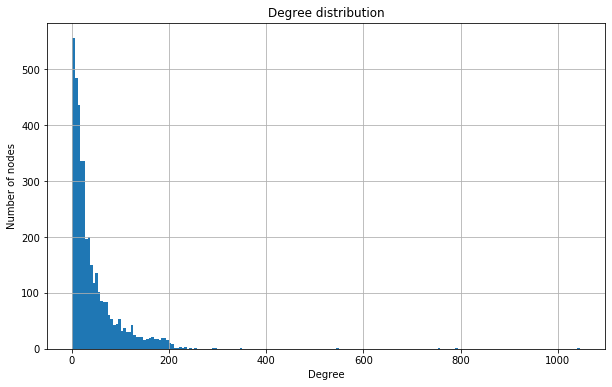

    Given the above plot and computed percentiles, we see a unique 
    mode around the median of  25.0 degrees, with rather fat tails.


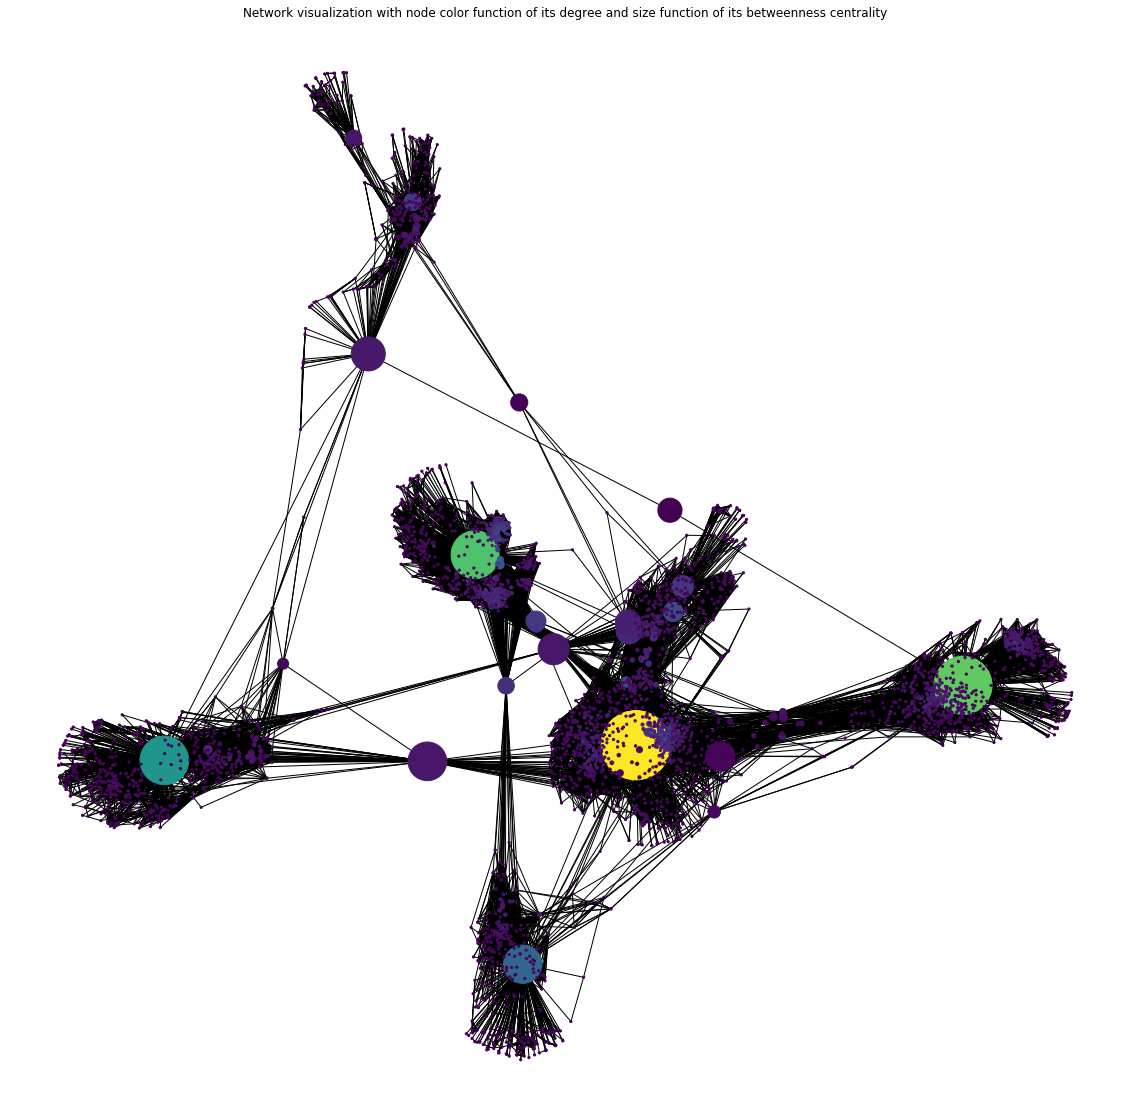

,page rank,degree centrality
3437,0.007615,0.135463
107,0.006936,0.258791
1684,0.006367,0.196137
0,0.006290,0.085934
1912,0.003877,0.186974



    As expected, the top five nodes with highest page rank also constitutes
    the top five of degree centrality, however they do not strictly share the same order.
    Note that this is not true anymore for nodes above top 5. We notice that node 107 with 
    highest degree centrality, has second highest page rank, while node 3437 with fifth highest
    degree centrality, has the highest page rank. This non-intuitive order should be linked to 
    how close each node is connected to the most central nodes available. Indeed, page rank decreases
    if the node is connected to a node with high degree.
    
Consider the top three nodes for degree and centrality as our nodes of focus
set_of_interest:  ['107', '1684', '1912']


,page rank with bias
1684,0.058985
107,0.057337
1912,0.055624
2047,0.001233
2313,0.001096
2543,0.001002
2951,0.000952
3101,0.000950
3291,0.000944
2347,0.000940


,page rank
3437,0.007615
107,0.006936
1684,0.006367
0,0.006290
1912,0.003877



    We notice that our bias had a huge impact on page rank since the set of first ten nodes 
    with highest page ranks has drastically changed, compared to the one with no bias.
    With respect to fraud analytics, in the event we thought fraud events as similar to one another, ideally
    leading to a homophilic network (homophily ==  tendency of individuals to associate and bond with similar others)
    with high assortativity coefficient, we could bias out page rank via varying weights. 

    
    Note, however, that this still requires expert knowledge and, at first sight, a (full) characterization of 
    a fraudulent behavior.
    In the event that latter was not clearly defined, or even masked by their abundance, biasing
    our page rank algorithm and analyzing its results should be made with caution.
    


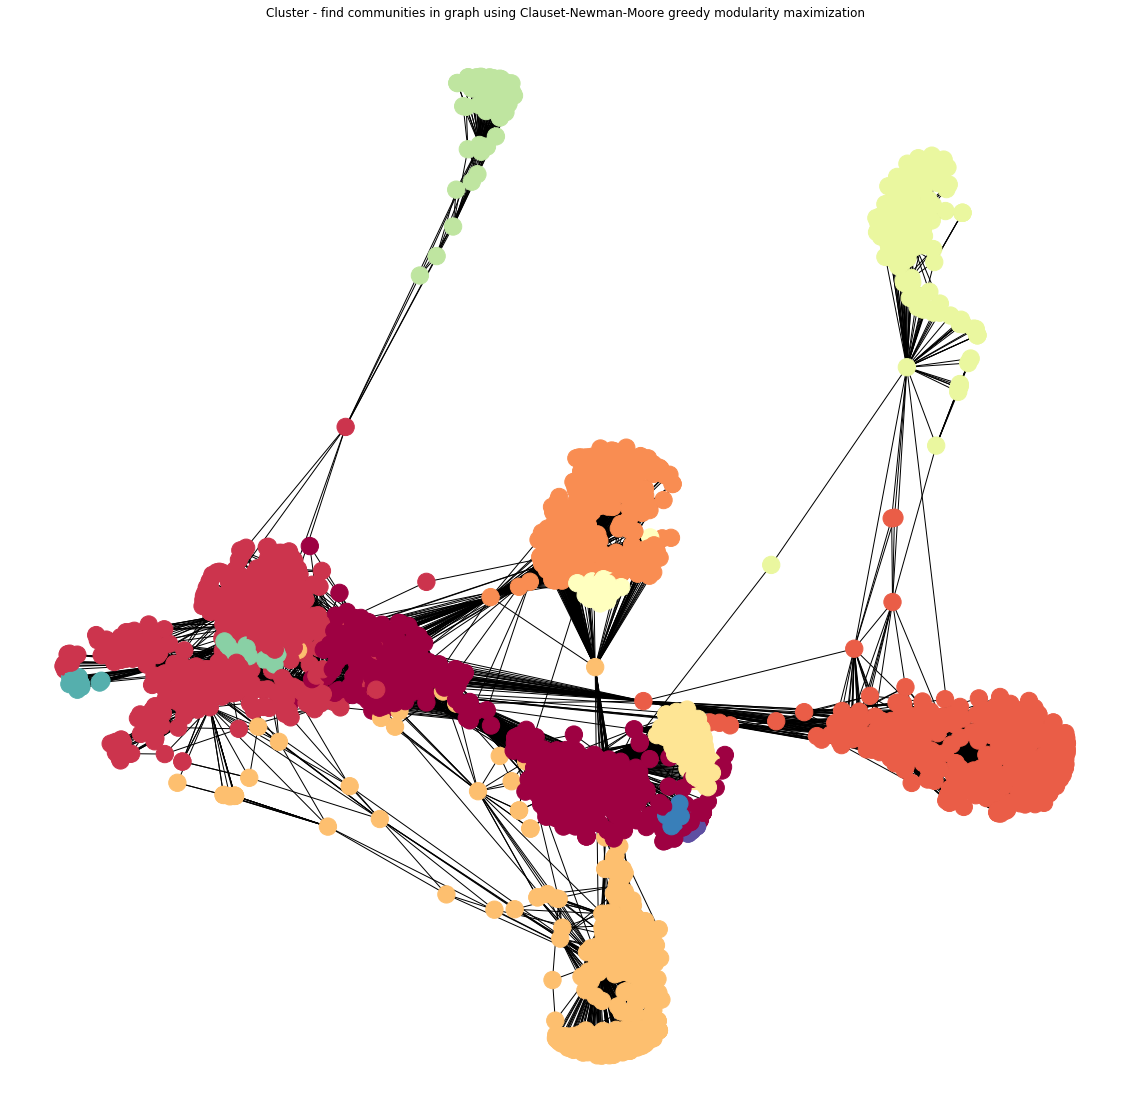

Index(['107', '58', '428', '563', '1684', '171', '348', '483', '414', '376'], dtype='object')

cost and coverage of first ten nodes by closeness centrality 

cost:  1890195   coverage:  0.5313196335726665
coverage_threshold:  0.3   cost_threshold:  800000


,coverage,cost,subset
48,0.324090,798170,"(58, 428, 563, 1684, 171, 348, 483, 414, 376)"
47,0.323843,798026,"(428, 563, 1684, 171, 348, 483, 414, 376)"
41,0.323595,780481,"(58, 428, 563, 1684, 171, 348, 483, 414)"
46,0.323347,784945,"(58, 563, 1684, 171, 348, 483, 414, 376)"
35,0.323347,780337,"(428, 563, 1684, 171, 348, 483, 414)"
40,0.323100,784801,"(563, 1684, 171, 348, 483, 414, 376)"
30,0.322852,767256,"(58, 563, 1684, 171, 348, 483, 414)"
18,0.322605,767112,"(563, 1684, 171, 348, 483, 414)"
45,0.321862,789889,"(58, 428, 1684, 171, 348, 483, 414, 376)"
44,0.321614,797686,"(58, 428, 563, 1684, 348, 483, 414, 376)"


In [10]:
def compute_all(graph: nx.Graph()):

    compute_basic_stats(graph)

    compute_degrees_statistics(graph)

    compute_hist(graph)

    visualize_network(graph)
    
    compute_page_rank(graph)
    
    compute_clustering(graph)
    
    compute_cost(graph)
    
compute_all(ntw)